# The White Shark Cafe

This notebook analyzes CROCO simulations for the manuscript (in preparation) "Annual migration of white sharks to the Eastern Subtropical Mode Water formation region" by Thomas, Wenegrat, and Block.



In [108]:
import xarray as xr
import xgcm
import numpy as np
import xroms
import matplotlib.pyplot as plt
from glob import glob
from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})


**Load Data**

The simulations involve a hierarchy of runs, starting with:
PACBIG (Full Pacific Domain, 12km, run by UCLA group)


In [129]:
def loadCroco(files):
    xrargsin = {
#        "combine":"nested",
        "compat": "override",
        "combine": "by_coords",
        "data_vars": "all",
        "coords": "minimal",
        "parallel": True,
    }


    #ds = xr.open_mfdataset(files, **xrargsin)
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal')
    ds = ds.chunk(chunks={'time':1, 's_rho':10, 's_w':10}) # Having to rechunk for some reason

    ds['Cs_r'] = (('s_rho'), ds.Cs_r)
    ds['Cs_w'] = (('s_w'), ds.Cs_w)

    ds, grid = xroms.roms_dataset(ds, Vtransform=2)
    
    ds['yearday'] = np.mod(ds.scrum_time/86400, 360)
    return ds, grid

Make a plot of vorticity to confirm the load and xroms is working

[########################################] | 100% Completed |  4.6s


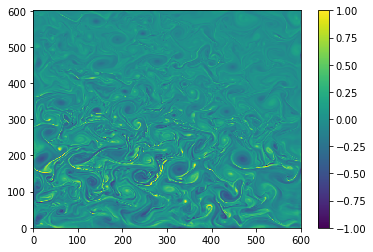

In [96]:
with ProgressBar():
    vort = ds.xroms.vort.isel(ocean_time=-1, s_w=-2)
    plt.pcolor(vort/ds.f.xroms.to_grid('psi') , vmin=-1, vmax=1)
    plt.colorbar()
    #dso.u.isel(ocean_time=-2, s_rho=-2).plot()
    #zeta.compute()

## Sort out the various runs
Need to figure out the order of nests, duration of each run, and which one to use.

Useful information in Weekly report from 191010.

In [170]:
# WHITESHARK
filepath = '/data/pacific/jacob/WHITESHARKCAFE/WHITESHARK/'
files = sorted(glob("%swhiteshark_his*.nc" % filepath))
ds, grid = loadCroco(files)
print(f'Yeardays: {ds.yearday.values[0]} - {ds.yearday.values[-1]}')
print(f'Total Months: {(ds.scrum_time.values[-1] - ds.scrum_time.values[0])/(86400*30)}')
print(f'Lats: {ds.lat_rho.values[-1, 0]} - {ds.lat_rho.values[0, 0]}')
print(f'DX, DY: {ds.dx.mean().values}, {ds.dy.mean().values}')


Yeardays: 195.0 - 279.0
Total Months: 14.8
Lats: 32.78992462158203 - 11.364108085632324
DX, DY: 3976.406494140625, 3976.403564453125


In [169]:
# WSHARK
filepath = '/data/pacific/jacob/WHITESHARKCAFE/WSHARK/'
files = sorted(glob("%swshark_his*.nc" % filepath))
ds, grid = loadCroco(files)
print(f'Yeardays: {ds.yearday.values[0]} - {ds.yearday.values[-1]}')
print(f'Total Months: {(ds.scrum_time.values[-1] - ds.scrum_time.values[0])/(86400*30)}')
print(f'Lats: {ds.lat_rho.values[-1, 0]} - {ds.lat_rho.values[0, 0]}')
print(f'DX, DY: {ds.dx.mean().values}, {ds.dy.mean().values}')


Yeardays: 180.0 - 270.0
Total Months: 27.0
Lats: 32.78992462158203 - 11.364108085632324
DX, DY: 3976.406494140625, 3976.403564453125


In [167]:
# MSHARK
filepath = '/data/pacific/jacob/WHITESHARKCAFE/MSHARK/'
files = sorted(glob("%smshark_his*.nc" % filepath))
ds, grid = loadCroco(files)
print(f'Yeardays: {ds.yearday.values[0]} - {ds.yearday.values[-1]}')
print(f'Total Months: {(ds.scrum_time.values[-1] - ds.scrum_time.values[0])/(86400*30)}')
print(f'Lats: {ds.lat_rho.values[-1, 0]} - {ds.lat_rho.values[0, 0]}')
print(f'DX, DY: {ds.dx.mean().values}, {ds.dy.mean().values}')


Yeardays: 180.0 - 269.0
Total Months: 14.966666666666667
Lats: 27.4332218170166 - 15.312803268432617
DX, DY: 1497.1895751953125, 1497.189208984375


In [156]:
# MSHARKNP
filepath = '/data/pacific/jacob/WHITESHARKCAFE/MSHARKNP/'
files = sorted(glob("%smshark_his*.nc" % filepath))
ds, grid = loadCroco(files)
print(f'Yeardays: {ds.yearday.values[0]} - {ds.yearday.values[-1]}')
print(f'Total Months: {ds.yearday.values.size/30}')
print(f'Lats: {ds.lat_rho.values[-1, 0]} - {ds.lat_rho.values[0, 0]}')
print(f'DX, DY: {ds.dx.mean().values}, {ds.dy.mean().values}')


Yeardays: 205.0 - 278.0
Total Months: 14.466666666666667
Lats: 27.4332218170166 - 15.312803268432617
DX, DY: 1497.1895751953125, 1497.189208984375


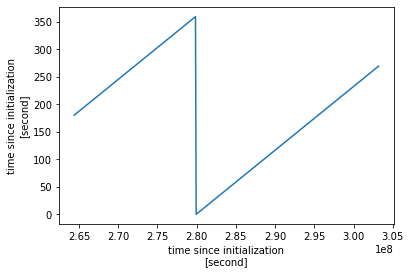

In [168]:
ds.yearday.plot()

## Confirm loading

We have several things that need to be confirmed:

- Confirm the vertical coordinate is correct in xroms (for CROCO)
- Confirm that density calculations in xroms is the same as CROCO EOS


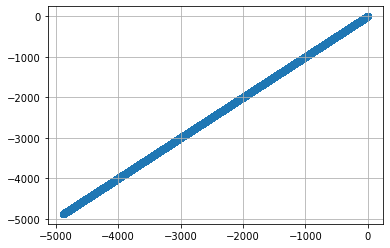

In [106]:
# Confirm vertical coordinate:
# These runs used the 'NEW_S_COORD' cppkey (which can be seen in ds.attrs)
# Equation below is from: https://croco-ocean.gitlabpages.inria.fr/croco_doc/model/model.grid.html

zo = (ds.hc*ds.s_rho + ds.h*ds.Cs_r)/(ds.hc + ds.h)
z = zo*ds.h # note that here assuming zeta = 0 (mean)


#plt.plot(z[:,:,:].ravel)
#plt.plot(ds.z_rho0[:,0,0])

plt.scatter(z.values.flatten(), ds.z_rho0.values.flatten())
plt.grid()
# Note a smarter way to validate is to just look at the code (:\), which indeed shows that Vtransform=2 is correct for NEW_S_COORD


In [ ]:
# Confirm density calculations:
# Painstaking hand comparison of Nonlinear/rho_eos.f and croco rho_eos.f indicates they are equivalent.


**Extras**

In [80]:
xrargsin = {
        "compat": "override",
        #"combine": "by_coords",
        "data_vars": "all",
        "coords": "minimal",
        #"parallel": True,
    }

ds0 = xr.open_dataset(filepath+'whiteshark_his.0000.nc')
ds1 = xr.open_dataset(filepath+'whiteshark_his.0010.nc')
xr.combine_by_coords((ds0, ds1),**xrargsin)

KeyboardInterrupt: 

In [10]:
dsj = xroms.open_netcdf('/data/pacific/jacob/CFB/SMODEPROP/jet_his.nc', chunks={}, Vtransform=2)
#dsj = xr.open_dataset('/data/pacific/jacob/CFB/SMODEPROP/jet_his.nc')
dsj

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 202, eta_v: 201, ocean_time: 91, s_rho: 60, s_w: 61, xi_rho: 52, xi_u: 51)
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 195 196 197 198 199 200 201
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * s_rho       (s_rho) float32 -0.9917 -0.975 -0.9583 ... -0.025 -0.008333
  * s_w         (s_w) float32 -1.0 -0.9833 -0.9667 ... -0.03333 -0.01667 0.0
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
  * ocean_time  (ocean_time) float64 0.0 1.728e+05 ... 1.538e+07 1.555e+07
    z_w         (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(91, 61, 202, 52), meta=np.ndarray>
    z_w_u       (ocean_time, s_w, eta_rho, xi_u) float32 dask.array<chunksize=(91, 61, 202, 51), meta=np.ndarray>
    z_w_v       (ocean_time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(91, 61, 201, 52), meta=np.ndarray>
    z_w_psi     (ocean_time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(91, 61, 201, 51), meta=np.ndarray>
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(91, 60, 202, 52), meta=np.ndarray>
    z_rho_u     (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(91, 60, 202, 51), meta=np.ndarray>
    z_rho_v     (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(91, 60, 201, 52), meta=np.ndarray>
    z_rho_psi   (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(91, 60, 201, 51), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(60, 202, 52), meta=np.ndarray>
    z_rho_u0    (s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(60, 202, 51), meta=np.ndarray>
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(60, 201, 52), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(60, 201, 51), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(61, 202, 52), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(61, 202, 51), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(61, 201, 52), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(61, 201, 51), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables:
    spherical   |S1 ...
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(61,), meta=np.ndarray>
    Cs_r        (s_rho) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    Cs_w        (s_w) float32 dask.array<chunksize=(61,), meta=np.ndarray>
    hc          float32 ...
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
    time_step   (ocean_time, auxil) int32 dask.array<chunksize=(91, 4), meta=np.ndarray>
    scrum_time  (ocean_time) float64 dask.array<chunksize=(91,), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(91, 202, 52), meta=np.ndarray>
    ubar        (ocean_time, eta_rho, xi_u) float32 dask.array<chunksize=(91, 202, 51), meta=np.ndarray>
    vbar        (ocean_time, eta_v, xi_rho) float32 dask.array<chunksize=(91, 201, 52), meta=np.ndarray>
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chu

In [116]:
ds = xr.open_mfdataset(files, chunks=[],**xrargsin)
ds = xr.open_dataset('/data/pacific/jacob/WHITESHARKCAFE/WHITESHARK/Exclude_whiteshark_his.0000.nc')
dsg = xr.open_dataset('/data/pacific/jacob/WHITESHARKCAFE/WHITESHARK/whiteshark_grd.nc')
#ds = ds.merge(dsg)
ds

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 602, eta_v: 601, s_rho: 80, s_w: 81, time: 10, xi_rho: 602, xi_u: 601)
Coordinates:
  * xi_rho      (xi_rho) float32 1.0 2.0 3.0 4.0 5.0 ... 599.0 600.0 601.0 602.0
  * xi_u        (xi_u) float32 1.5 2.5 3.5 4.5 5.5 ... 598.5 599.5 600.5 601.5
  * eta_rho     (eta_rho) float32 1.0 2.0 3.0 4.0 ... 599.0 600.0 601.0 602.0
  * eta_v       (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 598.5 599.5 600.5 601.5
  * s_rho       (s_rho) float32 -0.9937 -0.9812 -0.9688 ... -0.01875 -0.00625
  * s_w         (s_w) float32 -1.0 -0.9875 -0.975 -0.9625 ... -0.025 -0.0125 0.0
    lon_rho     (eta_rho, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_u       (eta_rho, xi_u) float32 ...
    lat_u       (eta_rho, xi_u) float32 ...
    lon_v       (eta_v, xi_rho) float32 ...
    lat_v       (eta_v, xi_rho) float32 ...
  * time        (time) float32 2.657e+08 2.658e+08 ... 2.664e+08 2.665e+08
Dimensions without coordinates: auxil
Data variables:
    spherical   |S1 ...
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 ...
    sc_w        (s_w) float32 ...
    Cs_r        (s_rho) float32 ...
    Cs_w        (s_w) float32 ...
    hc          float32 ...
    h           (eta_rho, xi_rho) float32 ...
    f           (eta_rho, xi_rho) float32 ...
    pm          (eta_rho, xi_rho) float32 ...
    pn          (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    time_step   (time, auxil) int32 ...
    scrum_time  (time) float32 ...
    zeta        (time, eta_rho, xi_rho) float32 ...
    u           (time, s_rho, eta_rho, xi_u) float32 ...
    v           (time, s_rho, eta_v, xi_rho) float32 ...
    temp        (time, s_rho, eta_rho, xi_rho) float32 ...
    salt        (time, s_rho, eta_rho, xi_rho) float32 ...
    omega       (time, s_w, eta_rho, xi_rho) float32 ...
    w           (time, s_w, eta_rho, xi_rho) float32 ...
    AKt         (time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    type:           ROMS history file
    title:          WHITESHARK
    date:           
    rst_file:       whiteshark_rst.nc
    his_file:       whiteshark_his.0000.nc
    grd_file:       whiteshark_grd.nc
    ini_file:       whiteshark_ini.nc
    frc_file:       whiteshark_frc.nc
    VertCoordType:  NEW
    skpp:           2005
    theta_s:        7.0
    theta_s_expl:   S-coordinate surface control parameter
    theta_b:        1.0
    theta_b_expl:   S-coordinate bottom control parameter
    Tcline:         500.0
    Tcline_expl:    S-coordinate surface/bottom layer width
    Tcline_units:   meter
    hc:             500.0
    hc_expl:        S-coordinate parameter, critical depth
    hc_units:       meter
    sc_w:           [-1.     -0.9875 -0.975  -0.9625 -0.95   -0.9375 -0.925  ...
    sc_w_expl:      S-coordinate at W-points
    Cs_w:           [-1.00000000e+00 -9.49043751e-01 -8.98449540e-01 -8.48551...
    Cs_w_expl:      S-coordinate stretching curves at W-points
    sc_r:           [-0.99375 -0.98125 -0.96875 -0.95625 -0.94375 -0.93125 -0...
    sc_r_expl:      S-coordinate at W-points
    Cs_r:           [-9.74499106e-01 -9.23679531e-01 -8.73394251e-01 -8.23957...
    Cs_r_expl:      S-coordinate stretching curves at RHO-points
    ntimes:         64800
    ndtfast:        80
    dt:             600.0
    dtfast:         7.5
    nwrt:           144
    tnu4:           0.0
    tnu4_expl:      biharmonic mixing coefficient for tracers
    units:          meter4 second-1
    Zob:            0.01
    Zob_expl:       VonKarman/Prandtl log layer : roughness scale
    Zob_units:      meter
    Cdb_max:        0.1
    Cdb_min:        1e-04
    Cdb_expl:       Range of quadratic drag coefficientr
    rho0:           1027.4
    rho0_expl:      Mean density used in Boussinesq approximation
    rho0_units:     kilogram meter-3
    gamma2:         1.0
    gamm

In [97]:
ds =dsj
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w
z_w
#ds.coords["z_w"] = z_w.cf.transpose(*[dim for dim in ["T", "Z", "Y", "X"] if dim in z_w.cf.get_valid_keys()])

<xarray.DataArray (ocean_time: 91, eta_rho: 202, xi_rho: 52, s_w: 61)>
dask.array<add, shape=(91, 202, 52, 61), dtype=float32, chunksize=(91, 202, 52, 61), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 195 196 197 198 199 200 201
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(202, 52), meta=np.ndarray>
  * ocean_time  (ocean_time) float64 0.0 1.728e+05 ... 1.538e+07 1.555e+07
  * s_w         (s_w) float32 -1.0 -0.9833 -0.9667 ... -0.03333 -0.01667 0.0
Attributes:
    long_name:      free-surface
    units:          meter
    field:          free-surface, scalar, series
    standard_name:  sea_surface_height
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

In [96]:
z_w

,Array,Chunk
Bytes,102.15 GB,2.35 GB
Shape,"(435, 602, 602, 81)","(10, 602, 602, 81)"
Count,442 Tasks,44 Chunks
Type,float64,numpy.ndarray


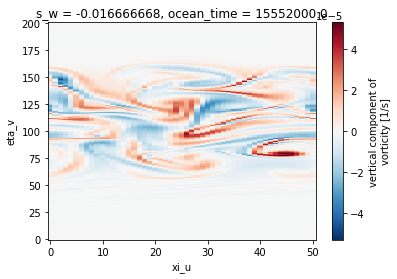

In [35]:
ds.xroms.vort.isel(ocean_time=-1, s_w=-2).plot()

In [39]:
dsg = xr.open_dataset('/data/pacific/jacob/WHITESHARKCAFE/WHITESHARK/whiteshark_grd.nc')
ds = xr.open_dataset('/data/pacific/jacob/WHITESHARKCAFE/WHITESHARK/whiteshark_his.0020.nc')
dsm = ds.merge(dsg)

In [52]:
(dsm.hc * dsm.s_rho + dsm.Cs_r * dsm.h) / (dsm.hc + dsm.h)

ValueError: operands could not be broadcast together with shapes (80,) (602,602) 